In [1]:
%env GEOMSTATS_BACKEND=pytorch

env: GEOMSTATS_BACKEND=pytorch


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

sys.path.append("..")

import os
import numpy as np
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")


from scipy.spatial.transform import Rotation
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

from utils.plotting import plot_so3
from utils.optimal_transport import so3_wasserstein as wasserstein
from foldflow.utils.so3_helpers import norm_SO3, expmap
from foldflow.utils.so3_condflowmatcher import SO3ConditionalFlowMatcher
from so3_experiments.models.models import PMLP

from torch.utils.data import DataLoader
from data.datasets import SpecialOrthogonalGroup

from geomstats._backend import _backend_config as _config

_config.DEFAULT_DTYPE = torch.cuda.FloatTensor

savedir = "models/so3_synthetic"
os.makedirs(savedir, exist_ok=True)

cuda:0
size of toy dataset:  50000


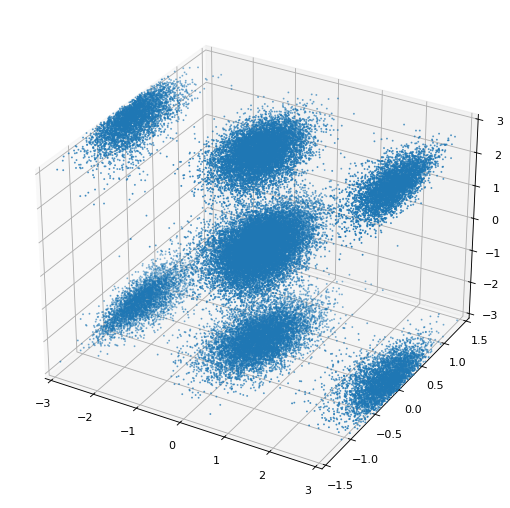

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load toy dataset
data = np.load("data/orthogonal_group.npy")
print("size of toy dataset: ", len(data))

fig = plot_so3(data)
plt.savefig("figs/so3_synthetic_data.png", dpi=300)
plt.show()

### Dataloader

In [ ]:
# load data
trainset = SpecialOrthogonalGroup(split="train")
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=0)

valset = SpecialOrthogonalGroup(split="valid")
valloader = DataLoader(valset, batch_size=256, shuffle=False, num_workers=0)

testset = SpecialOrthogonalGroup(split="test")
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)

### CFM

This is an SO(3) CFM it calculates the flow at $r_t$:
        $$u_t(r_t | r_0, r_1) = \log_{r_t}(r_0)/t$$

In [10]:
so3_group = SpecialOrthogonal(n=3, point_type="matrix")
FM = SO3ConditionalFlowMatcher(manifold=so3_group)

### Loss Function

The final loss corresponds to equation (3) in the paper:

$$\mathcal{L}_{\mathrm{foldflowbase},-\mathrm{SO(3)}}(\theta) = \mathbb{E}_{t\sim \mathcal{U}(0,1), q(r_0,r_1), \rho_t(r_t | r_0, r_1)} \left \|v_\theta(t, r_t) - \log_{r_t}(r_0)/t\right\|_{\mathrm{SO(3)}}^2$$

In [ ]:
def loss_fn(v, u, x):
    res = v - u  # residual between 2 flows on the tangent space
    # norm-squared on SO(3), x is the sampled point on the geodesic from x0 to x1, which  lies on the tangent space
    norm = norm_SO3(x, res)
    loss = torch.mean(norm, dim=-1)
    return loss

### ODE Inference

In [ ]:
# ODE inference on SO(3)
def inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(torch.cat([xt, t[:, None]], dim=-1))  # vt on the tangent space of xt
        vt = rearrange(vt, "b (c d) -> b c d", c=3, d=3)
        xt = rearrange(xt, "b (c d) -> b c d", c=3, d=3)
        xt_new = expmap(xt, vt * dt)  # expmap to get the next point
    return rearrange(xt_new, "b c d -> b (c d)", c=3, d=3)

### Model

In [ ]:
dim = 9  # network ouput is 9 dimensional (3x3 matrix)

# MLP with a projection at the end, projection on to the tanget space of the manifold
model = PMLP(dim=dim, time_varying=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [14]:
print("Models parameters dtype: ", next(model.parameters()).dtype)

Models parameters dtype:  torch.float64


### Training Loop

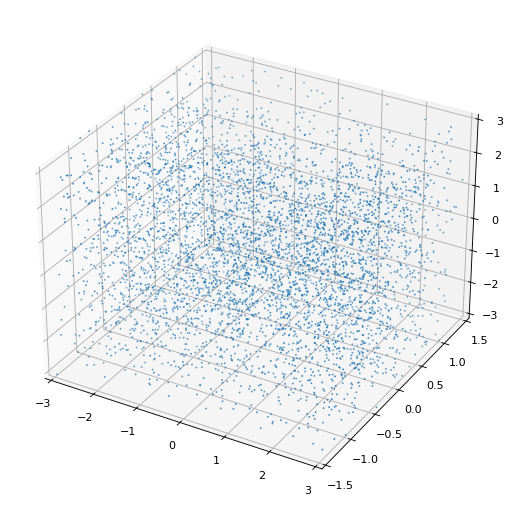

wassterstein-1 distance: 1.041141125979129
wassterstein-2 distance: 1.230933953557587


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# ODE inference on SO(3)
def inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(torch.cat([xt, t[:, None]], dim=-1))  # vt on the tangent space of xt
        vt = rearrange(vt, "b (c d) -> b c d", c=3, d=3)
        xt = rearrange(xt, "b (c d) -> b c d", c=3, d=3)
        xt_new = expmap(xt, vt * dt)  # expmap to get the next point, using Euler's step on SO(3)
    return rearrange(xt_new, "b c d -> b (c d)", c=3, d=3)


def main_loop(model, optimizer, num_epochs=150, display=True):
    losses = []
    w1ds = []
    w2ds = []
    global_step = 0

    for epoch in range(num_epochs):

        if display:
            progress_bar = tqdm(total=len(trainloader))
            progress_bar.set_description(f"Epoch {epoch}")

        if (epoch % 10) == 0:
            n_test = testset.data.shape[0]
            traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
            for t in torch.linspace(0, 1, 200):
                t = torch.tensor([t]).to(device).repeat(n_test).requires_grad_(True).type_as(traj)
                dt = torch.tensor([1 / 200]).to(device)
                traj = inference(model=model, xt=traj, t=t, dt=dt)
            final_traj = rearrange(traj, "b (c d) -> b c d", c=3, d=3)

            w_d1 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=1)
            w_d2 = wasserstein(torch.tensor(testset.data).to(device).double().detach(), final_traj.detach(), power=2)
            w1ds.append(w_d1)
            w2ds.append(w_d2)

            if display:
                plot_so3(final_traj)
                plt.show()
                print("wassterstein-1 distance:", w_d1)
                print("wassterstein-2 distance:", w_d2)

        for _, data in enumerate(trainloader):
            optimizer.zero_grad()
            x1 = data.to(device)
            x0 = torch.tensor(Rotation.random(x1.size(0)).as_matrix()).to(device)

            t, xt, ut = FM.sample_location_and_conditional_flow_simple(x0.double(), x1.double())

            vt = model(torch.cat([rearrange(xt, "b c d -> b (c d)", c=3, d=3), t[:, None]], dim=-1))
            vt = rearrange(vt, "b (c d) -> b c d", c=3, d=3)

            loss = loss_fn(vt, ut, xt)
            losses.append(loss.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            if display:
                progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "step": global_step}
                progress_bar.set_postfix(**logs)
                global_step += 1

    return model, np.array(losses), np.array(w1ds), np.array(w2ds)


model, losses, w1s, w2s = main_loop(model, optimizer, num_epochs=2, display=True)

### Results for Multiple Runs

In [26]:
model_new = PMLP(dim=dim, time_varying=True).to(device)
print("Models parameters dtype: ", next(model_new.parameters()).dtype)

Models parameters dtype:  torch.float64


In [ ]:
w1ds_runs = []
w2ds_runs = []
losses_runs = []

num_runs = 5

for i in range(num_runs):
    print("doing run ", i)
    model = PMLP(dim=dim, time_varying=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    model, losses, w1ds, w2ds = main_loop(model, optimizer, num_epochs=10, display=False)

    w1ds_runs.append(w1ds)
    w2ds_runs.append(w2ds)
    losses_runs.append(losses)

losses_runs = np.array(losses_runs)
w1ds_runs = np.array(w1ds_runs)
w2ds_runs = np.array(w2ds_runs)

doing run  0
doing run  1
doing run  2
doing run  3
doing run  4


### Plot Results

In [28]:
# mean of w1s
w1s_mean = np.mean(w1ds_runs, axis=0)
w1s_std = np.std(w1ds_runs, axis=0)

# mean of w2s
w2s_mean = np.mean(w2ds_runs, axis=0)
w2s_std = np.std(w2ds_runs, axis=0)

In [ ]:
print("w1s_mean", w1s_mean[-1])
print("w1s_std", w1s_std[-1])
print("w2s_mean", w2s_mean[-1])
print("w2s_std", w2s_std[-1])

w1s_mean 0.9776881756547031
w1s_std 0.032618638547290676
w2s_mean 1.1497144943892377
w2s_std 0.04020464803441786


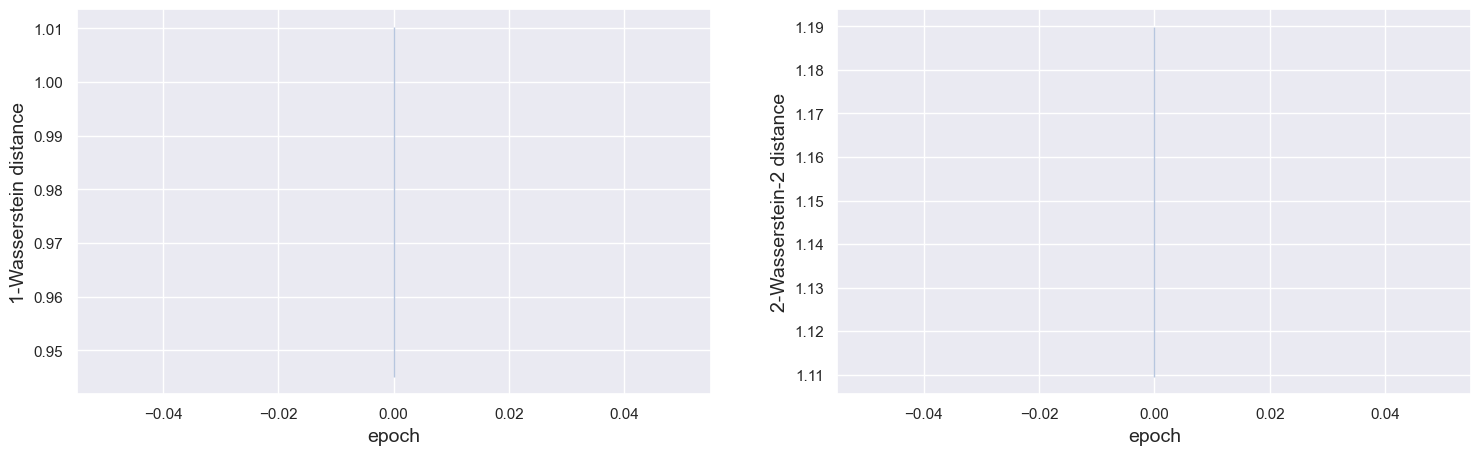

In [ ]:
import seaborn as sns

sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

x = np.arange(0, 1, 1)

ax[0].plot(x, w1s_mean)
ax[0].fill_between(x, w1s_mean - w1s_std, w1s_mean + w1s_std, color="C0", alpha=0.4)
ax[0].set_xlabel("epoch", fontsize=14)
ax[0].set_ylabel("1-Wasserstein distance", fontsize=14)

ax[1].plot(x, w2s_mean)
ax[1].fill_between(x, w2s_mean - w2s_std, w2s_mean + w2s_std, color="C0", alpha=0.4)
ax[1].set_xlabel("epoch", fontsize=14)
ax[1].set_ylabel("2-Wasserstein-2 distance", fontsize=14)
plt.show()

5


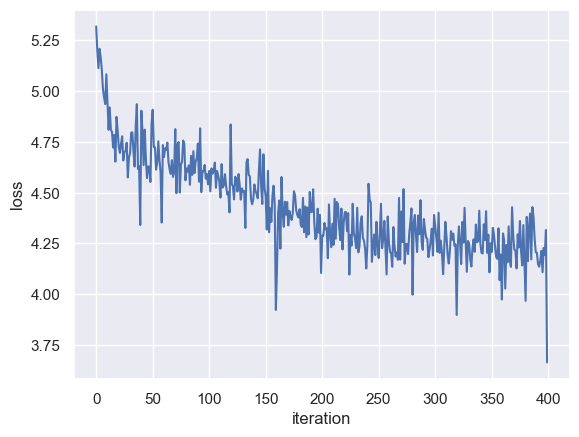

In [ ]:
print(len(losses_runs))
plt.plot(losses_runs[0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

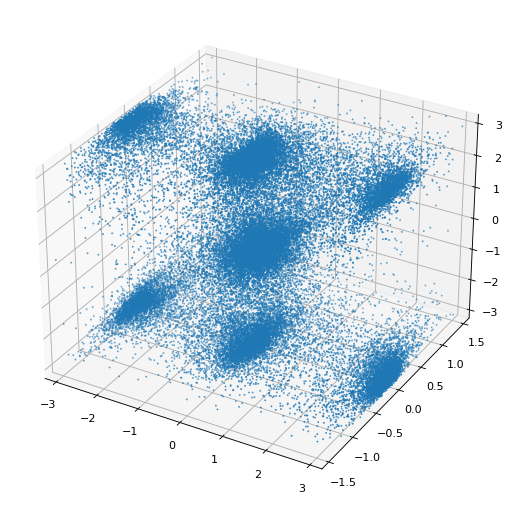

In [ ]:
# inference on the full dataset for visualization
plt.style.use("default")
n_test = data.shape[0]
traj = torch.tensor(Rotation.random(n_test).as_matrix()).to(device).reshape(-1, 9)
for t in torch.linspace(0, 1, 200):
    t = torch.tensor([t]).to(device).repeat(n_test)
    dt = torch.tensor([1 / 200]).to(device)
    traj = inference(model, traj, t, dt)
final_traj = rearrange(traj, "b (c d) -> b c d", c=3, d=3)
fig = plot_so3(final_traj)
plt.show()